In [213]:
import import_ipynb

In [214]:
import numpy as np
import math
import matplotlib.pyplot as plt

import mpl_toolkits.mplot3d
from scipy.misc import derivative
from sympy import *

In [215]:
x1, x2 = symbols('x1 x2')

f_x = sqrt(x1**2 + x2**2 + 1) + 0.5 * x1 - 0.5 * x2

### Utilities

In [216]:
epsilon = 1e-5
derivative_spacing = 1e-10

# Given dimensions
n = 2

# Start point
x_0 = [2, 2]

# For modified Newton's method
p = 3

In [217]:
def partialBy(by, func = f_x):
    return diff(func, by)

### Gradient functions

In [218]:
def gradient():
    return np.array([partialBy(x1), partialBy(x2)])

f_gradient = gradient()

In [219]:
def gradientIn(x):
    x_1 = float(partialBy(x1).subs({x1:x[0], x2:x[1]}))
    x_2 = float(partialBy(x2).subs({x1:x[0], x2:x[1]}))
    
    return np.array([x_1, x_2])

### Hessian functions

In [220]:
def Hessian():
    x_11 = diff(f_gradient[0], x1)
    x_12 = diff(f_gradient[0], x2)
    x_21 = diff(f_gradient[1], x1)
    x_22 = diff(f_gradient[1], x2)
    
    return np.array([[x_11, x_12],
                     [x_21, x_22]])

In [221]:
def HessianIn(x):
    x_11 = float(partialBy(x1, f_gradient[0]).subs({x1:x[0], x2:x[1]}))
    x_12 = float(partialBy(x2, f_gradient[0]).subs({x1:x[0], x2:x[1]}))
    x_21 = float(partialBy(x1, f_gradient[1]).subs({x1:x[0], x2:x[1]}))
    x_22 = float(partialBy(x2, f_gradient[1]).subs({x1:x[0], x2:x[1]}))
    
    return np.array([[x_11, x_12],
                     [x_21, x_22]])

### Functions for one-dimension minimization

In [222]:
def displayResult(f, x, i):
    print(f"Alpha minimization:")
    print(f"\tIterations = {i}")
    print(f"\tPoint = ({x}, {f(x)})")

def findLocalizedSections(f, x = 0, h = 0.001):
    temp = [] 
    array = [] 
    
    if(f(x) < f(x + h)): 
        h = -h; 
        
    while(f(x) > f(x + h)):
        x = x + h 
        temp.append(x) 
        h = 2 * h 
        
    temp.append(x + 0.5 * h); 
    temp.append(x + h); 

    if (f(temp[-2]) > f(temp[-3])): 
            a = temp[- 4]; 
            b = temp[ - 2]; 

    if (f(temp[- 2]) <= f(temp[ - 3])): 
            a = temp[- 1] 
            b = temp[- 3] 


    if(a > b): 
        t = b 
        b = a 
        a = t

    return(a, b)

def bisectionMethod(f, a, b):
    assert a <= b, "'a' cannot be greater than 'b'"
    
    iterations = 0
    
    x_k = (a + b) / 2
    while (abs(a - b) > epsilon):
        iterations = iterations + 1
        
        f_k_derivative = derivative(f, x_k, dx = derivative_spacing)
        
        if (f_k_derivative == 0):
            x_k = (a + b) / 2
            break
        elif (f_k_derivative > 0):
            b = x_k
        elif (f_k_derivative < 0):
            a = x_k
            
        x_k = (a + b) / 2
        
    x_min = x_k
    displayResult(f, x_min, iterations)
    
    return x_min

In [223]:
def output(x_k, x_k_1, k):
    print('k =', k)
    print('x_k =', x_k)
    print('x_k_1 =', x_k_1, '\n')

## Functions for multidimension minimization

In [224]:
alpha = Symbol('alpha')

def modifiedNewtonMethod(p):
    k = 0
    f_grad_x_0 = gradientIn(x_0)
    if(np.linalg.norm(f_grad_x_0) <= epsilon):
        return x_0
    
    f_inverse_x_k = np.linalg.inv(HessianIn(x_0))

    x_1 = x_0 - alpha * f_inverse_x_k.dot(f_grad_x_0)
    f_x_1 = f_x.subs({x1:x_1[0], x2:x_1[1]})

    a, b = findLocalizedSections(lambdify(alpha, f_x_1))
    alpha_k = bisectionMethod(lambdify(alpha, f_x_1), a, b)
    
    x_1 = x_0 - alpha_k * f_inverse_x_k.dot(f_grad_x_0)
    
    # FINDING ALPHA BY DIVIDING BY TWO
    
    #alpha_k = 1
    #x_1 = x_0 - alpha_k * f_inverse_x_0.dot(f_grad_x_0)
    #while(f_x.subs({x1:x_1[0], x2:x_1[1]}) > f_x.subs({x1:x_0[0], x2:x_0[1]})):
    #        alpha_k = alpha_k / 2
    #        x_1 = x_0 - alpha_k * f_inverse_x_k.dot(f_grad_x_0)
    
    
    output(x_0, x_1, k)
    
    if(np.linalg.norm(x_1 - x_0) <= epsilon):
        return x_1
    
    x_k = x_0
    x_k_1 = x_1
    
    k = 1
    while(np.linalg.norm(x_k_1 - x_k) > epsilon):
        x_k = x_k_1
        
        f_grad_x_k = gradientIn(x_k)
        
        # Checking if we need to recompute inverse Hessian
        if((k // p) * p == k):
            print("New inverse Hessian is coming")
            f_inverse_x_k = np.linalg.inv(HessianIn(x_k))

        # Finding alpha
        x_k_1 = x_k - alpha * f_inverse_x_k.dot(f_grad_x_k)
        f_x_k_1 = f_x.subs({x1:x_k_1[0], x2:x_k_1[1]})

        a, b = findLocalizedSections(lambdify(alpha, f_x_k_1))
        alpha_k = bisectionMethod(lambdify(alpha, f_x_k_1), a, b)
        
        # Finding x_k+1
        x_k_1 = x_k - alpha_k * f_inverse_x_k.dot(f_grad_x_k)
        
        # FINDING ALPHA BY DIVIDING BY TWO
        
        #alpha_k = 1
        #x_k_1 = x_k - alpha_k * f_inverse_x_k.dot(f_grad_x_k)
        #while(f_x.subs({x1:x_k_1[0], x2:x_k_1[1]}) > f_x.subs({x1:x_k[0], x2:x_k[1]})):
        #    alpha_k = alpha_k / 2
        #    x_k_1 = x_k - alpha_k * f_inverse_x_k.dot(f_grad_x_k)
            
        output(x_k, x_k_1, k)
        
        k = k + 1
    
    return x_k_1, k
    

In [225]:
def broydensMethod():
    k = 0
    f_grad_x_0 = gradientIn(x_0)
    if(np.linalg.norm(f_grad_x_0) <= epsilon):
        return x_0
    
    H_0 = np.identity(n)
    
    x_1 = x_0 - alpha * H_0.dot(f_grad_x_0)
    f_x_1 = f_x.subs({x1:x_1[0], x2:x_1[1]})
    
    a, b = findLocalizedSections(lambdify(alpha, f_x_1))
    alpha_k = bisectionMethod(lambdify(alpha, f_x_1), a, b)
    
    x_1 = x_0 - alpha_k * H_0.dot(f_grad_x_0)

    output(x_1, x_1, k)
    
    if(np.linalg.norm(x_1 - x_0) <= epsilon):
        return x_1
    
    x_k = x_0
    x_k_1 = x_1
    H_k = H_0
    
    while(np.linalg.norm(x_k_1 - x_k) > epsilon):
        # Finding H_k
        delta_x_k = np.subtract(x_k_1, x_k)
        delta_y_k = np.subtract(gradientIn(x_k_1), gradientIn(x_k))

        numerator = (delta_x_k - H_k.dot(delta_y_k)).dot((delta_x_k - H_k.dot(delta_y_k))[np.newaxis].T)[0]
        denominator = (delta_x_k - H_k.dot(delta_y_k)).dot(delta_y_k)

        H_k = H_k + numerator / denominator
    
        x_k = x_k_1
        
        f_grad_x_k = gradientIn(x_k)
        
        # Finding alpha
        x_k_1 = x_k - alpha * H_k.dot(f_grad_x_k)
        f_x_k_1 = f_x.subs({x1:x_k_1[0], x2:x_k_1[1]})

        a, b = findLocalizedSections(lambdify(alpha, f_x_k_1))
        alpha_k = bisectionMethod(lambdify(alpha, f_x_k_1), a, b)
        
        # Finding x_k+1
        x_k_1 = x_k - alpha_k * H_k.dot(f_grad_x_k)
        
        output(x_k, x_k_1, k)
        
        k = k + 1
    
    return x_k_1, k

## Showing Results

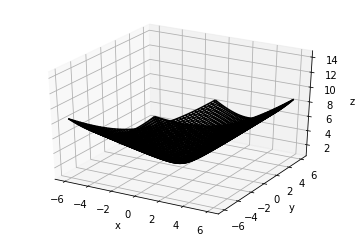

In [226]:
ax = plt.axes(projection="3d")
z_function = lambdify([x1, x2], f_x)

x = np.linspace(-6, 6, 100)
y = np.linspace(-6, 6, 100)

X, Y = np.meshgrid(x, y)
Z = z_function(X, Y)

ax = plt.axes(projection="3d")
ax.plot_wireframe(X, Y, Z, color='black')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [227]:
(x_min_broydens, k_b) = broydensMethod()

Alpha minimization:
	Iterations = 18
	Point = (2.70308984375, 0.8237040113202885)
k = 0
x_k = [-1.15360482  1.54948503]
x_k_1 = [-1.15360482  1.54948503] 

Alpha minimization:
	Iterations = 16
	Point = (0.65579296875, 0.7886169018720924)
k = 0
x_k = [-1.15360482  1.54948503]
x_k_1 = [-1.34337503  1.2005816 ] 

Alpha minimization:
	Iterations = 13
	Point = (4.217500000000001, 0.7248600542633867)
k = 1
x_k = [-1.34337503  1.2005816 ]
x_k_1 = [-0.93238885  0.62225327] 

Alpha minimization:
	Iterations = 15
	Point = (0.22966796874999998, 0.7085868189872991)
k = 2
x_k = [-0.93238885  0.62225327]
x_k_1 = [-0.77247961  0.77414176] 

Alpha minimization:
	Iterations = 9
	Point = (2.9710000000000005, 0.7071398243149746)
k = 3
x_k = [-0.77247961  0.77414176]
x_k_1 = [-0.70165456  0.71520439] 

Alpha minimization:
	Iterations = 6
	Point = (1.423, 0.7071069536374432)
k = 4
x_k = [-0.70165456  0.71520439]
x_k_1 = [-0.70790985  0.70765268] 

Alpha minimization:
	Iterations = 2
	Point = (1.53500000000

In [228]:
x_min_mod_newton, k_n = modifiedNewtonMethod(p)

Alpha minimization:
	Iterations = 14
	Point = (0.11270703124999999, 0.8599260263150883)
k = 0
x_k = [2, 2]
x_k_1 = [-0.19778711  0.14033398] 

Alpha minimization:
	Iterations = 15
	Point = (0.29803515625, 0.7624902573617016)
k = 1
x_k = [-0.19778711  0.14033398]
x_k_1 = [-0.27329063  0.66513626] 

Alpha minimization:
	Iterations = 13
	Point = (0.04794921875, 0.727436772177729)
k = 2
x_k = [-0.27329063  0.66513626]
x_k_1 = [-0.49634828  0.47632969] 

New inverse Hessian is coming
Alpha minimization:
	Iterations = 13
	Point = (1.2433750000000003, 0.7071074625973298)
k = 3
x_k = [-0.49634828  0.47632969]
x_k_1 = [-0.70603053  0.70798898] 

Alpha minimization:
	Iterations = 1
	Point = (1.0230000000000001, 0.7071067913971025)
k = 4
x_k = [-0.70603053  0.70798898]
x_k_1 = [-0.70696251  0.70720012] 

Alpha minimization:
	Iterations = 17
	Point = (1.2639804687500003, 0.7071067812659741)
k = 5
x_k = [-0.70696251  0.70720012]
x_k_1 = [-0.70711317  0.70709268] 

New inverse Hessian is coming
Alph

## Comparison

In [229]:
print("Broyden's method: x_min =", x_min_broydens)
print("Modified Newton's method: x_min =", x_min_mod_newton)
print("\nNorm = ", np.linalg.norm(x_min_broydens - x_min_mod_newton))
print("\nBroyden's method iterations: k =", k_b)
print("Modified Newton's method iterations: k =", k_n)

Broyden's method: x_min = [-0.70709962  0.7070856 ]
Modified Newton's method: x_min = [-0.70710683  0.70710667]

Norm =  2.2273247704856398e-05

Broyden's method iterations: k = 13
Modified Newton's method iterations: k = 8
